In [29]:
import pandas as pd
import numpy as np
from math import floor

df = pd.read_csv("CSIRO_Recons_gmsl_yr_2019.csv", header=0, index_col=0)
df.drop(columns=["GMSL uncertainty (mm)"], axis=1, inplace=True)
df.rename(columns={"Time": "year", "GMSL (mm)": "sea_level"}, inplace=True)

df.index = np.floor(df.index).astype(int)
df.index = pd.to_datetime(df.index, format="%Y").year
df.head()

,sea_level
Time,
1880,-30.3
1881,-24.7
1882,-41.5
1883,-36.2
1884,-15.3


In [30]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
 
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
# best_cfg = evaluate_models(df.values, p_values, d_values, q_values)

In [31]:
# Rebuild ARIMA using best configuration
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]

predictions = list()
for t in range(len(test)):
  model = ARIMA(history, order=(1,2,1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history.append(test[t])

In [32]:
display(test)

array([[102.8],
       [ 96.8],
       [108.7],
       [107.1],
       [106.1],
       [104.4],
       [110.8],
       [105.9],
       [111.9],
       [124.3],
       [118.5],
       [126.9],
       [126. ],
       [115.7],
       [116.3],
       [116.9],
       [121.6],
       [126.1],
       [127.5],
       [130.6],
       [133.4],
       [128.9],
       [132.3],
       [136.9],
       [142.1],
       [149.1],
       [137.8],
       [147.6],
       [151.2],
       [156.7],
       [159.6],
       [168.1],
       [166.8],
       [167.2],
       [171.3],
       [172.7],
       [181.1],
       [187.5],
       [194.2],
       [195.4],
       [202.4],
       [200.2],
       [210.9],
       [207.8],
       [208.1],
       [215.1],
       [216.6],
       [227.3]])

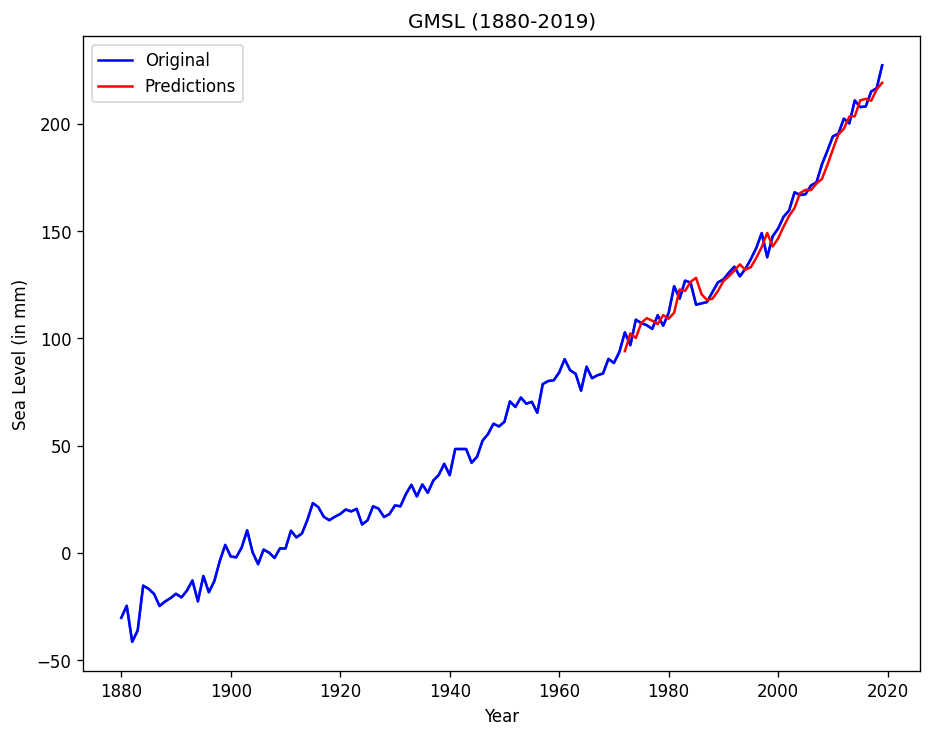

In [33]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

plt.plot(df["sea_level"])

x = [i for i in range(1972, 2020)]
y = predictions
plt.plot(df["sea_level"], label='Original', color='blue')
plt.plot(x, y, label='Predictions', color='red')

# Labelling 

plt.xlabel("Year")
plt.ylabel("Sea Level (in mm)")
plt.title("GMSL (1880-2019)")

# Display
plt.savefig('predictions.pdf', facecolor='white')
plt.legend()
plt.show()

In [34]:
# Predict until 2035
predictions_to_2035 = predictions
for t in range(16):
  model = ARIMA(history, order=(1,2,1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions_to_2035.append(yhat)
  history.append([yhat])

In [35]:
print(len(predictions), len(predictions_to_2035))

64 64


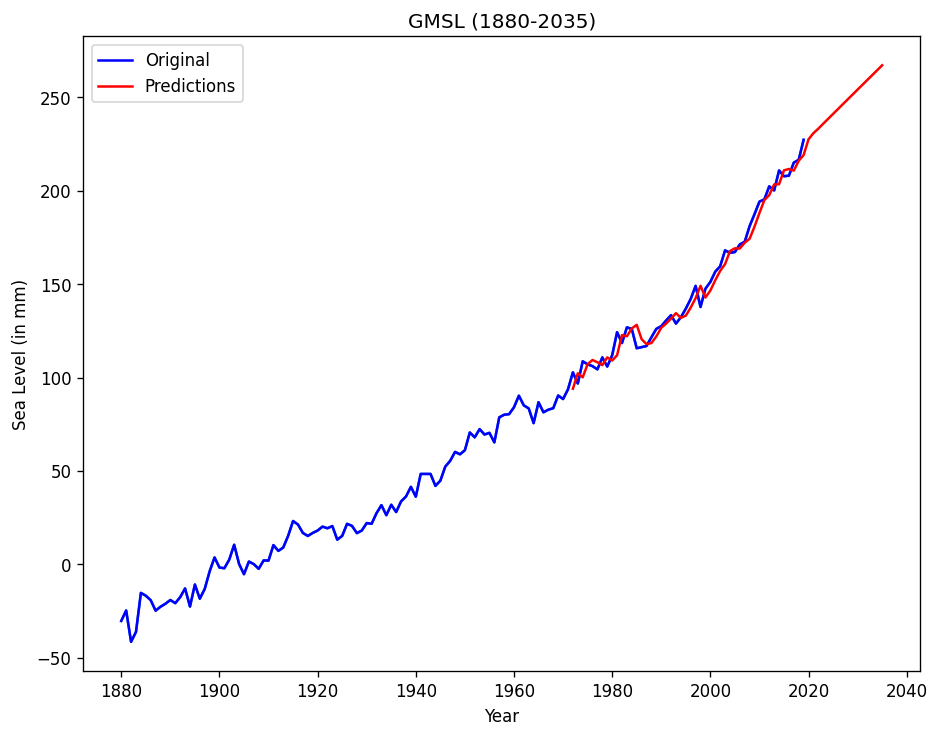

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

plt.plot(df["sea_level"])

x = [i for i in range(1972, 2036)]
y = predictions_to_2035
plt.plot(df["sea_level"], label='Original', color='blue')
plt.plot(x, y, label='Predictions', color='red')

# Labelling 

plt.xlabel("Year")
plt.ylabel("Sea Level (in mm)")
plt.title("GMSL (1880-2035)")

# Display
plt.savefig('predictions_to_2035.pdf', facecolor='white')
plt.legend()
plt.show()